In [1]:
import os
import json
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager


In [2]:
TYPE = "local" # can either by local or distributed

In [3]:
def print_stats(data):
    print(f"min: {np.min(data)}")
    print(f"max: {np.max(data)}")
    print(f"mean: {np.mean(data)}")
    print(f"stdev: {np.std(data)}")

# Analyze server Celery side

We use flower as a no-code way to monitor celery task execution. See README for more details. Flower renders a nice table of stats at http://localhost:5555/ for us to analyze. The below code just parses it as a pandas DataFrame.

In [4]:
# start flower by navigating to root of webserver and running
# export REDIS_URL=<REDIS URL FOR REVIEW APP>
# celery --app celery_worker.celery_instance flower
# THIS MUST BE DONE BEFORE LOAD TEST STARTS
url = "http://localhost:5555/tasks"

In [5]:
driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - ====== WebDriver manager ======


[WDM] - Current google-chrome version is 88.0.4324
[WDM] - Get LATEST driver version for 88.0.4324
[WDM] - Get LATEST driver version for 88.0.4324
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/88.0.4324.96/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/jmathur25/.wdm/drivers/chromedriver/mac64/88.0.4324.96]


In [17]:
driver.get(url)

In [18]:
# click through all pages of data and read html as pandas dataframe
dfs = []
while True:
    html = driver.page_source
    df = pd.read_html(html)
    dfs.append(df[1])
    
    # navigate to next page until can't
    button = driver.find_element_by_id("tasks-table_next")
    button_class = button.get_attribute("class")
    if button_class == 'paginate_button next disabled':
        break
    button.click() 
    time.sleep(0.1) # clicking too fast can cause races with JS execution

In [19]:
df = pd.concat(dfs)

In [20]:
# only look at this task
df = df[ df['Name'] == 'app.celery.aws_ecs_creation.assign_container' ]

In [21]:
# should be how many you ran, but for large load tests
# flower might miss a few cause it does not poll workers fast enough
df.shape

(20, 10)

In [22]:
# percentage that succeeded
(df['State'] == "SUCCESS").mean()

0.95

In [23]:
pd.unique(df['State'])

array(['SUCCESS', 'STARTED'], dtype=object)

In [15]:
df[df['State'] == 'STARTED']

,Name,UUID,State,args,kwargs,Result,Received,Started,Runtime,Worker
2,app.celery.aws_ecs_creation.assign_container,c8dec425-5f34-46db-a996-c14f51e0aa50,STARTED,"('test_user_19', 'fractal-dev-browsers-chrome'...",{'webserver_url': 'fractal-serv-jmather625-5e5...,NaN,2021-02-26 22:25:15.916,2021-02-26 22:25:16.134,NaN,celery@a1f70d7a-5f40-4d3c-89fa-d643a2388f4a


In [16]:
df[df['State'] == 'FAILURE']

,Name,UUID,State,args,kwargs,Result,Received,Started,Runtime,Worker


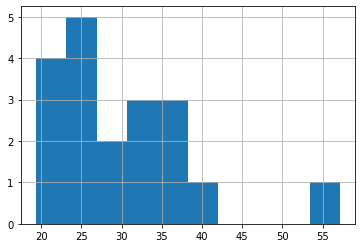

In [60]:
df['Runtime'].hist()

In [61]:
print_stats(df['Runtime'])

min: 19.329
max: 57.175
mean: 29.831157894736837
stdev: 8.582010924100775


In [62]:
print_stats(df['Runtime'])

min: 19.329
max: 57.175
mean: 29.831157894736837
stdev: 8.582010924100775


# Analyze client side

In [94]:
savedir = "aws_lambda_dump" if TYPE == "distributed" else "local_dump"
files = os.listdir(savedir)



In [95]:
def load_distributed_data(fp):
    data = json.load(fp)
    # load body as json and save as so
    data['body'] = json.loads(data['body'])
    assert data['statusCode'] == 200
    data = data['body']
    return data

def load_local_data(fp):
    data = fp.read()
    return json.loads(data)

In [96]:
load_test_data = []
for f in files:
    data = None
    with open(os.path.join(savedir, f)) as fp:
        if TYPE == "distributed":
            data = load_distributed_data(fp)
        else:
            data = load_local_data(fp)
    load_test_data += data

In [97]:
# scan for errors
for i, data in enumerate(load_test_data):
    if len(data['errors']) > 0:
        task_id = data['task_id']
        errors = data['errors']
        print(f"Task {task_id} experienced errors: {errors}")

Task 199c419e-05e2-43c8-b824-4abb5ed09a85 experienced errors: ["Error in polling status of assign container. Message: Task failed with output: Received an Exception that could not be processed: 'exc_type'"]
Task cd2ea677-bda0-435a-9ef8-d38956495f15 experienced errors: ["Error in polling status of assign container. Message: Task failed with output: Received an Exception that could not be processed: 'exc_type'"]
Task e8aa9df2-51a4-42d4-bcaa-fa5472a301a2 experienced errors: ["Error in polling status of assign container. Message: Task failed with output: Received an Exception that could not be processed: 'exc_type'"]


In [88]:
all_status_codes = []
all_web_times = []
request_container_times = []
poll_container_times = []
for data in load_test_data:
    all_status_codes += data['status_codes']
    all_web_times += data['web_times']
    request_container_times.append(data['request_container_time'])
    pct = data['poll_container_time']
    if pct is not None:
        poll_container_times.append(pct)

(array([1456.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          20.]),
 array([200. , 200.2, 200.4, 200.6, 200.8, 201. , 201.2, 201.4, 201.6,
        201.8, 202. ]),
 <a list of 10 Patch objects>)

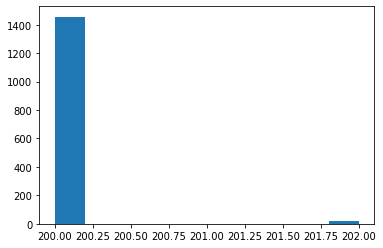

In [89]:
plt.hist(all_status_codes)

In [90]:
np.unique(all_status_codes, return_counts=True)

(array([200, 202]), array([1456,   20]))

In [91]:
print_stats(all_web_times)

min: 0.13612008094787598
max: 3.65461802482605
mean: 0.20370344579381347
stdev: 0.20027085339647874


In [92]:
print_stats(request_container_times)

min: 0.14497709274291992
max: 0.45579004287719727
mean: 0.2006298065185547
stdev: 0.06942662753183064


In [93]:
print_stats(poll_container_times)

min: 24.05774998664856
max: 102.81924676895142
mean: 50.87954281568527
stdev: 29.35344047790953
